# Digit Recognizer
  - Learn computer vision fundamentals with the famous MNIST data
  - https://www.kaggle.com/competitions/digit-recognizer

# 패키지

In [4]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from torch.utils.tensorboard import SummaryWriter

In [6]:
if not os.path.isdir('checkpoint') :
    os.mkdir('checkpoint')

if not os.path.isdir('submission') :
    os.mkdir('submission')

# 데이터셋

## Train

In [7]:
train_df = pd.read_csv('train.csv')
train_size = len(train_df)

train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
w = 28
h = 28

In [9]:
def show_train_data(idx) :
    tmp = train_df.iloc[idx]
    label, data = tmp[0], tmp[1:].to_numpy().reshape(h, w)

    plt.imshow(data, cmap='gray')
    print('Label : {}'.format(label))

    plt.show()

In [10]:
def convert_dataset(df) :
    l = len(df)

    labels = df['label'].to_numpy().astype(np.int8)

    datas = df.iloc[:, 1:].to_numpy().reshape(l, h, w).astype(np.int32)

    dataset = TensorDataset(torch.Tensor(datas), torch.Tensor(labels))

    return dataset

In [11]:
def show_train_dataset(idx) :
    data, label = train_dataset[idx]

    plt.imshow(data, cmap='gray')
    print('Label : {}'.format(label))

    plt.show()

In [12]:
train_dataset = convert_dataset(train_df)

In [13]:
total_size = len(train_dataset)

train_size = int(total_size * 0.8)
val_size = int(total_size * 0.2)

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [14]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

## Test

In [15]:
test_df = pd.read_csv('Test.csv')

test_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def convert_test_dataset(df) :
    l = len(df)

    datas = df.to_numpy().reshape(l, h, w).astype(np.int32)

    dataset = TensorDataset(torch.Tensor(datas))

    return dataset

def show_test_dataset(idx) :
    data = test_dataset[idx][0]

    plt.imshow(data, cmap='gray')

    plt.show()

In [17]:
test_dataset = convert_test_dataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size)

## 데이터 살펴보기

In [ ]:
show_train_dataset(5)

In [ ]:
show_test_dataset(0)

# 모델

## Linear

In [37]:
class LinearModel(nn.Module) : 
    def __init__(self) :
        super().__init__()

        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 32)
        self.linear3 = nn.Linear(32, 10)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x) :
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)

        return x

## CNN

In [39]:
class CNNModel(nn.Module) :
    def __init__(self) :
        super().__init__()

        # (1, 28, 28) -> (4, 24, 24) -> (4, 12, 12)
        self.conv1 = nn.Conv2d(1, 4, 5, 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # (4, 12, 12) -> (20, 8, 8) -> (20, 4, 4)
        self.conv2 = nn.Conv2d(4, 20, 5, 1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # (20, 4, 4) -> (20 * 4 * 4) -> (64) -> (10)
        self.fc1 = nn.Linear(20*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x) :
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## AlexNet

In [19]:
def _calc_conv_out_features(input_size, kernal_size, stride, padding) :
    output_height = (input_size[0] + 2 * padding - kernal_size[0]) // stride + 1
    output_width = (input_size[1] + 2 * padding - kernal_size[1]) // stride + 1

    return (output_height, output_width)

In [29]:
_calc_conv_out_features((7, 7), (3, 3), 1, 1)

(7, 7)

In [33]:
class AlexNet_28(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        # (1, 28, 28) -> (96, 28, 28) -> (96, 14, 14)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, 5, 1, 2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # (96, 14, 14) -> (256, 14, 14) -> (256, 7, 7)
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # (256, 7, 7) -> (384, 7, 7) -> (256, 7, 7) -> (256, 3, 3)
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
        )

        # (256, 3, 3) -> (256 * 3 * 3) -> (4096) -> (10)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),

            nn.Linear(4096, 10),
        )

    def forward(self, x) :
        x = x.view(-1, 1, 28, 28)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

# 학습

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
def train(model, criterion, optimizer, epoch, train_dataloader, log=True) :
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = correct / total * 100.
    avg_loss = train_loss / total

    if log and epoch % 5 == 4 :
        print('[ Train Epoch : {} ]'.format(epoch + 1))
        print('Train Accuracy : {}'.format(train_accuracy))
        print('Train Average Loss : {}'.format(avg_loss))

    return (train_accuracy, avg_loss)

In [36]:
def validate(model, criterion, epoch, val_dataloader, log=True) :
    model.eval()
    
    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(val_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets.long()).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = correct / total * 100.
    avg_loss = val_loss / total

    if log and epoch % 5 == 4 :
        print('[ Validate Epoch : {} ]'.format(epoch + 1))
        print('Accuracy : {}'.format(accuracy))
        print('Average Loss : {}'.format(avg_loss))

    return (accuracy, avg_loss)

In [38]:
model = AlexNet_28()
model = model.to(device)
model_name = 'AlexNet_28.pt'
model_name_for_writer = model_name[:-3]

epochs = 100
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
save_accuracy = 0

writer = SummaryWriter()

In [40]:
for i in tqdm(range(epochs)) :
    train_acc, train_loss = train(model, criterion, optimizer, i, train_dataloader, log=False)
    val_acc, val_loss = validate(model, criterion, i, val_dataloader, log=False)

    if save_accuracy < val_acc :
        save_accuracy = val_acc
        torch.save(model.state_dict(), 'checkpoint/{}'.format(model_name))
        
    writer.add_scalar('{}/Acc/Train'.format(model_name_for_writer), train_acc, i)
    writer.add_scalar('{}/Loss/Train'.format(model_name_for_writer), train_loss, i)
    
    writer.add_scalar('{}/Acc/Val'.format(model_name_for_writer), val_acc, i)
    writer.add_scalar('{}/Loss/Val'.format(model_name_for_writer), val_loss, i)

writer.flush()
writer.close() 

  3%|▎         | 3/100 [24:17<13:05:30, 485.88s/it]


KeyboardInterrupt: 

# 혼동 행렬

In [60]:
def get_confusion_matrix(model, n_classes, calc_dataloader) :
    model.eval()

    confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int32)

    for i, (inputs, targets) in enumerate(tqdm(calc_dataloader)) :
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)

        for target, predict in zip(targets.view(-1), predicted.view(-1)) :
            confusion_matrix[target.long(), predict.long()] += 1

    return confusion_matrix

In [80]:
def plot_confusion_matrix(model, n_classes, calc_dataloader) :
    cf_mat = get_confusion_matrix(model, n_classes, calc_dataloader)

    print("[ Count by Class ]")
    print(cf_mat.sum(1))

    print('[ Visualization ]')
    res = pd.DataFrame(cf_mat.numpy(), index = list(range(n_classes)), columns=list(range(n_classes)))
    res.index.name = 'Target Label'
    res.columns.name = 'Predicted Label'

    plt.figure(figsize=(10, 7))
    sns.heatmap(res, annot=True, fmt='d', cmap='Blues')
    plt.show()

    print('[ Accuracy by Class ]')
    print(cf_mat.diag() / cf_mat.sum(1))

    print('[ Total Accuracy ]')
    print(cf_mat.diag().sum() / cf_mat.sum())

In [1]:
model = CNNModel()
model = model.to(device)
model.load_state_dict(torch.load('checkpoint\CNN.pt'))

plot_confusion_matrix(model, 10, val_dataloader)

NameError: name 'CNNModel' is not defined

# 제출

In [47]:
def submission(model, test_dataloader) :
    model.eval()

    result = []
    with torch.no_grad() :
        for i, inputs in enumerate(tqdm(test_dataloader)) :
            inputs = inputs[0].to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            result.extend(predicted.tolist())

    submission_df = pd.DataFrame({'label':result})
    submission_df.index.name = 'ImageId'
    submission_df.index = submission_df.index + 1

    submission_df.to_csv('submission.csv')
    submission_df.to_csv('submission/{}.csv'.format(model_name_for_writer))

    return submission_df


In [52]:
model = CNNModel()
model = model.to(device)
model.load_state_dict(torch.load('checkpoint\CNN.pt'))

sub_df = submission(model, test_dataloader)

100%|██████████| 110/110 [00:00<00:00, 168.52it/s]


3


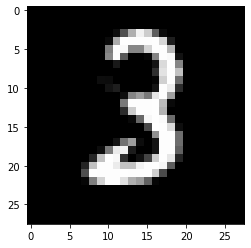

In [58]:
idx = 4
print(sub_df['label'].iloc[idx])
show_test_dataset(idx)